First we import lim and all the required packages

In [41]:
#Make sure to have lim in your pythonpath from your e.g., bash_rc
from lim import lim
import source.tools._utils as ut
import source.tools._vid_tools as vut
from source.mass_luminosity import SFR_Mz_2dinterp,process_fq

#keep track of for loops
from tqdm import tqdm

#numpy and scipy
import numpy as np
from scipy.interpolate import interp1d as i1d

#units and constants
import astropy.units as u
import astropy.constants as cu

#plotting routines and options
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
import matplotlib.colors as clrs
import matplotlib.cm as cmap
from matplotlib.collections import LineCollection

#import colors (from https://nbviewer.org/urls/dl.dropbox.com/s/s5z37r0xtrp5jss/colors.ipynb?flush_cache=true2)
kitsune   = '#D9972F'
seiheki   = '#478384'
shuan     = '#740A00'
aonibi      = '#324356'
shion       = '#968ABD'
suoko     = '#B23E52'
koiai       = '#002E4E'
seihakuji = '#EBF4F4'
shikon    = '#400B36'
ominaeshi   = '#F2F2B0'
seishitsu = '#184212'
naeiro    = '#B0CA71'
kinari    = '#F7EFE3'

%matplotlib inline

colors = [suoko,seiheki,kitsune,'#79a43a',aonibi,shion,'#828282']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.labelweight'] = 'bold'

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'],'weight':'bold'})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')# \

#color maps for colorbars
def makemap(cols):
    cmap = clrs.LinearSegmentedColormap.from_list("", cols)
    return cmap

blues = makemap([koiai,seiheki,seihakuji])
reds = makemap([shikon,kitsune,ominaeshi])
greens = makemap([seishitsu,naeiro,kinari])

### Useful functions

In [29]:
def Dnu_from_Dz(nu,z,Dz):
    '''
    Returns the bandwith required for a given rest-frame frequency nu
    and redshift width Dz centered at redshift z
    '''
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

##############################################

def Gauss(x,mu,sig2):
    '''
    Gaussian PDF
    '''
    exparg = -0.5*x**2/sig2
    norm = (2.*np.pi*sig2)**0.5
    return np.exp(exparg)/norm


##########################################################

def Add_noise(T,Tout,PT,Pzero,sig2):
    '''
    Adds a noise PDF to a given PDF convoluting them
    
    params: 
    T: temperature vector
    PT: PDF of temperature
    Pzero: The value of P(T=0) (i.e., P(N=0))
    sig2: variance of the noise PDF
    '''
    conv = np.zeros(len(Tout))*PT.unit
    for i in range(len(Tout)):
        conv[i] = np.trapz(Gauss(Tout[i]-T,0.,sig2)*PT,T)
    conv += Pzero*Gauss(Tout,0.,sig2)
    
    return conv

########################################################

def make_line(x,y,ax,vals,cm,lw):
    '''
    Generates a line with color which depends on x
    '''
    norm = plt.Normalize(0,1)
    points = np.array([x,y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cm, norm=norm)
    lc.set_array(vals)
    lc.set_linewidth(lw)
    ax.add_collection(lc)
    return

#####################################################

def nutick(nu,text,color,ax,factor=1,arrow=False):
    '''
    Gets the tick on the colorbar
    '''
    arrowdict = dict(arrowstyle='-')
    ax.vlines(np.log10(nu.value),0,10,color,lw=3,zorder=10)
    if arrow:
        ax.annotate(text,(np.log10(nu.value),0.5),(factor*np.log10(nu.value),1.6),color='black',va='center',ha='center',fontsize=15,arrowprops=arrowdict)
    else:
        ax.text(factor*np.log10(nu.value),1.6,text,color='black',ha='center',fontsize=15,va='center')

    return

###########################################

def nu_from_lambda(lam):
    '''
    Get the frequency (in GHz) corresponding to a given wavelength
    '''
    return (cu.c/lam).to(u.GHz)

##################################################

def lognormal(x,mu,sigma):
    '''
    Returns a lognormal PDF as function of x with mu and sigma 
    being the mean of log(x) and standard deviation of log(x), respectively
    '''
    try: 
        return 1/x/sigma/(2.*np.pi)**0.5*np.exp(-(np.log(x.value) - mu)**2/2./sigma**2)
    except:
        return 1/x/sigma/(2.*np.pi)**0.5*np.exp(-(np.log(x) - mu)**2/2./sigma**2)

### Call lim

In [17]:
lim_params = dict()

#fiducial cosmology
cosmo_fid = dict(cosmo_input_camb={'H0':67.36,'ombh2':0.02237,'omch2':0.12,
                  'As':2.1e-9,'ns':0.9649,'mnu':0.06, 'f_NL':0})

#CO(1-0) rest frame frequency
nu=115.271*u.GHz

zObs=2.9
Dz=1
nuObs,Dnu=Dnu_from_Dz(nu,zObs,Dz)


model_params = dict(nu=nu, nuObs=nuObs,
                    sigma_scatter=0.42, #L scatter
                    hmf_model='Tinker', #halo mass function model
                    bias_model='Tinker10', #halo bias model
                    model_type='ML', # Model using L(M) relations
                    Mmin = 1e10*u.Msun, Mmax=1e15*u.Msun, # Extreme halo masses
                    #We use TonyLi model to have the effect of sigma_SFR included
                    model_name='TonyLi',
                    #parameters to match Kamenetzky 2016. quenching according to UniverseMachine, SFR(M) according to #Behroozi, Wechsler and Conroy 2013
                    #Matching choices of UniverseMachine for SFR
                    model_par={'alpha':1.27, 'beta':-1, 'dMF':1.7226,'SFR_file':'sfr_release.dat','sig_SFR':0.3,'do_quench':True},
                    #use halo model and RSD
                    do_onehalo=True, do_RSD=True, 
                    #Apply smoothing
                    smooth=True,
                    #Convolve with survey mask (cylinder volume)
                    do_conv_Wkmin=True,
                    #k extreme values, number of bins in k, mu and M
                    kmin=10**-2.5*u.Mpc**-1, kmax=3*u.Mpc**-1,
                    nk=500, nmu=50, nM=1000,
                    #To compute VID, temperature range for the VID, temperature bins, max number of gals/voxel
                    Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**23, Ngal_max=30,
                    #Extreme values of luminosities
                    Lmin=0.5e-1*u.Lsun,Lmax=1e10*u.Lsun,
                    #no cut-off in luminosity (exponential cut off at 0)
                    dndL_Lcut=0*u.Lsun)

obs_params = dict(Delta_nu=Dnu, dnu=31.25*u.MHz, #bandwidth and spectral resolution
                  beam_FWHM=1*u.arcmin, #angular resolution
                  #Area surveyed in the sky
                  Omega_field=200*u.deg**2)    

lim_params.update(cosmo_fid)
lim_params.update(model_params)
lim_params.update(obs_params)



In [18]:
M = lim(lim_params)


We're going to compute first the power spectrum and the VID, reproducing Figures 6 and 7 of arXiv: 2206.xxxxx

In addition to the fiducial model above, we're varying some parameters:

In [38]:
#Sets of models only changing sig_SFR

model_par1={'alpha':1.27, 'beta':-1, 'dMF':1.7226,'SFR_file':'sfr_release.dat','sig_SFR':0.3,'do_quench':True}
model_par2={'alpha':1.27, 'beta':-1, 'dMF':1.7226,'SFR_file':'sfr_release.dat','sig_SFR':0.8,'do_quench':True}
model_par3={'alpha':1.27, 'beta':-1, 'dMF':1.7226,'SFR_file':'sfr_release.dat','sig_SFR':0.1,'do_quench':True}

models = [model_par1,model_par2,model_par3]


### Compute the power spectrum multipoles

In [39]:
#Store monopole and quadrupole, first smooth

Pk_0_smooth = []
Pk_2_smooth = []

for mod in models:
    #update to new model
    M.update(model_par = mod)
    
    Pk_0_smooth.append(M.Pk_0)
    Pk_2_smooth.append(M.Pk_2)


Note: redshifts have been re-sorted (earliest first)


In [40]:
#Store monopole and quadrupole, now without smoothing

M.update(smooth=False)

Pk_0 = []
Pk_2 = []
Pshots = []

for mod in models:
    #update to new model
    M.update(model_par = mod)
    
    Pk_0.append(M.Pk_0)
    Pk_2.append(M.Pk_2)
    Pshots.append(M.Pshot)


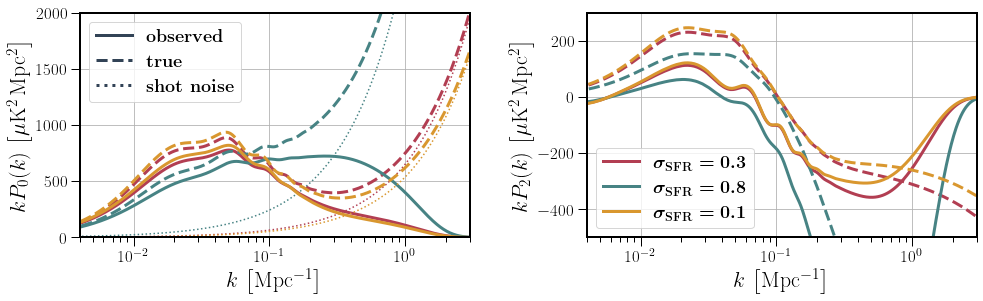

In [41]:
#Now we can make the plot, showing k*P(k) for representation reasons

gs = gridspec.GridSpec(1, 2,left=0.08,bottom=0.20,right=0.97,top=0.98,wspace=.3,hspace=.0)
fig = plt.figure(figsize=(14,4))

#################################

ax = plt.subplot(gs[0,0])

for i in range(len(models)):

    ax.semilogx(M.k,M.k*Pk_0_smooth[i],color=colors[i])
    ax.semilogx(M.k,M.k*Pk_0[i],color=colors[i],ls='--')
    ax.semilogx(M.k,M.k*Pshots[i],color=colors[i],ls=':',lw=1.5)

# dummy lines for the legend
ax.semilogx(M.k.value-10,M.k,color=aonibi,label=r'\bf{observed}')
ax.semilogx(M.k.value-10,M.k,ls='--',color=aonibi,label=r'\bf{true}')
ax.semilogx(M.k.value-10,M.k,ls=':',color=aonibi,label=r'\bf{shot noise}')

#aesthetics and labels
ax.set_xlim(4e-3,3)
ax.set_ylim(0,2000)
ax.tick_params(axis='both',width=1,length=9,labelsize=17)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=17)
ax.set_ylabel(r'${kP_0(k)\,\left[\mu{\rm K^2\,Mpc^2}\right]}$',fontsize=22)
ax.set_xlabel(r'${k\,\left[{\rm Mpc^{-1}}\right]}$',fontsize=22)
ax.legend(loc='upper left',ncol=1,fontsize=18)
ax.grid()

#####################################################


ax = plt.subplot(gs[0,1])

ax.semilogx(M.k,M.k*Pk_2_smooth[0],color=colors[0],label=r'$\boldsymbol{\sigma_{\rm SFR} = 0.3}$')
ax.semilogx(M.k,M.k*Pk_2[0],color=colors[0],ls='--')

ax.semilogx(M.k,M.k*Pk_2_smooth[1],color=colors[1],label=r'$\boldsymbol{\sigma_{\rm SFR} = 0.8}$')
ax.semilogx(M.k,M.k*Pk_2[1],color=colors[1],ls='--')

ax.semilogx(M.k,M.k*Pk_2_smooth[2],color=colors[2],label=r'$\boldsymbol{\sigma_{\rm SFR} = 0.1}$')
ax.semilogx(M.k,M.k*Pk_2[2],color=colors[2],ls='--')

#aesthetics and labels
ax.set_xlim(4e-3,3)
ax.set_ylim(-500,300)
ax.tick_params(axis='both',width=1,length=9,labelsize=17)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=17)
ax.set_ylabel(r'${kP_2(k)\,\left[\mu{\rm K^2\,Mpc^2}\right]}$',fontsize=22)
ax.set_xlabel(r'${k\,\left[{\rm Mpc^{-1}}\right]}$',fontsize=22)
ax.legend(loc='lower left',ncol=1,fontsize=18)
ax.grid()

plt.show()

### Compute the VID

In [48]:
PTl = []
PTl_noise = []
PTl_nomean = []
PTl_nomean_noise = []

sigmaN = 5*u.uK #Assume 5 uK noise per voxel
sig2 = sigmaN**2
Nsigma = 5 #Go for Nsigma in the Gaussian noise PDF

#Temperature array lists
TTl_nomean = []
Toutl_nomean = []
Tmean = []

#Get the noise PDF
#Set a T array to include also noise, out of convolution
Tmax = max(Nsigma*sig2.value**0.5,M.T[-1].value)
TTe = np.linspace(-Nsigma*sig2.value**0.5,Tmax,2**15)*M.T.unit
TT = vut.binedge_to_binctr(TTe)

#Compute noise
PTN = Gauss(TT,0.,sig2).to((TT**-1).unit)

for mod in models:
    #updatee the model
    M.update(model_par = mod)
    
    #ALWAYS print the normalization to make sure the VID is computed properly
    #if very different from 1, try increasing nT or ngal_max (if sum(PofN)<1), or changing the limits of Tmin_VID, Tmax_VID
    print(M.normalization)
    
    #Add a buffer in the T array and P(T) vector at T<0 for the noise
    TT2=np.concatenate((np.linspace(-Nsigma*sig2.value**0.5,0,400)*M.T.unit,M.T))
    PT=np.concatenate((np.zeros(400)*M.PT.unit,M.PT))

    #Prepare the output array
    Toute_nomean = np.linspace(-Nsigma*sig2.value**0.5-M.Tmean.value,Tmax,2**8+1)*M.T.unit
    Tout_nomean = vut.binedge_to_binctr(Toute_nomean)
    
    #Remove the mean and add noise
    TTnomean = TT2-M.Tmean
    PT_total_nomean = Add_noise(TTnomean,Tout_nomean,PT,M.PT_zero,sig2)

    PTl.append(PT)
    PTl_nomean_noise.append(PT_total_nomean)
    Toutl_nomean.append(Tout_nomean)



/Users/jlbernal/lim/source/line_model.py:781: RuntimeWarning: divide by zero encountered in log
  CLF_of_M[iM,:] = lognormal(self.L,np.log(self.LofM[iM].value)-0.5*sigma_base_e**2.,sigma_base_e)*self.dndM[iM]


0.9972100635515592
0.9968962356201522
0.9973060268817495


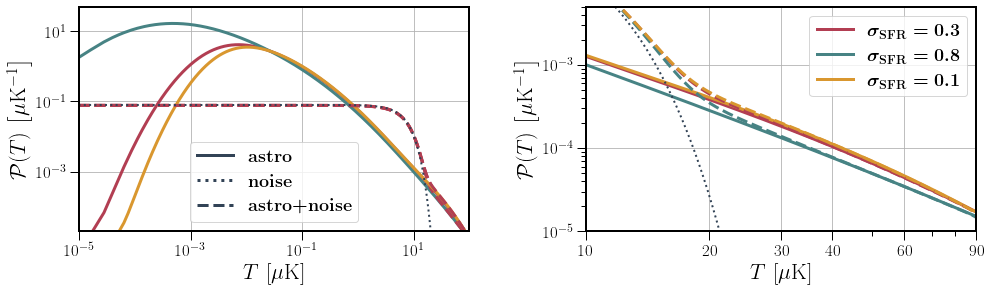

In [49]:
#Now we can make the plot

gs = gridspec.GridSpec(1, 2,left=0.08,bottom=0.20,right=0.97,top=0.98,wspace=.3,hspace=.0)
fig = plt.figure(figsize=(14,4))

#################################

ax = plt.subplot(gs[0,0])

for i in range(len(models)):
    ax.loglog(TT2,PTl[i],color=colors[i])
    ax.loglog(Toutl_nomean[i],PTl_nomean_noise[i],color=colors[0],ls='--')

ax.loglog(TT,PTN,color=aonibi,ls=':',lw=2)

#Dummy plots for the legend
ax.semilogy(M.k.value-10,M.k,color=aonibi,label=r'\bf{astro}')
ax.semilogy(M.k.value-10,M.k,ls=':',color=aonibi,label=r'\bf{noise}')
ax.semilogy(M.k.value-10,M.k,ls='--',color=aonibi,label=r'\bf{astro+noise}')

#aesthetics and labels
ax.set_xlim(1e-5,100)
ax.set_ylim(2e-5,50)
ax.tick_params(axis='both',width=1,length=9,labelsize=17)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=17)
ax.set_ylabel(r'${\mathcal{P}(T)\,\left[\mu{\rm K^{-1}}\right]}$',fontsize=22)
ax.set_xlabel(r'${T\,\left[\mu{\rm K}\right]}$',fontsize=22)
ax.legend(loc='lower center',ncol=1,fontsize=18)
ax.grid()

#################################

ax = plt.subplot(gs[0,1])

#Plot the zoom
ax.semilogy(TT2,PTl[0],color=colors[0],label=r'$\boldsymbol{\sigma_{\rm SFR} = 0.3}$')
ax.semilogy(TT2,PTl[1],color=colors[1],label=r'$\boldsymbol{\sigma_{\rm SFR} = 0.8}$')
ax.semilogy(TT2,PTl[2],color=colors[2],label=r'$\boldsymbol{\sigma_{\rm SFR} = 0.1}$')

for i in range(len(models)):
    ax.semilogy(Toutl_nomean[i],PTl_nomean_noise[i],color=colors[i],ls='--')

ax.semilogy(TT,PTN,color=aonibi,ls=':',lw=2)

#aesthetics and labels
ax.loglog()
ax.set_xlim(10,90)
ax.set_ylim(1e-5,5e-3)
ax.set_xticks([10,20,30,40,60,90])
ax.set_xticklabels([10,20,30,40,60,90])
ax.tick_params(axis='both',width=1,length=9,labelsize=17)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=17)
ax.set_ylabel(r'${\mathcal{P}(T)\,\left[\mu{\rm K^{-1}}\right]}$',fontsize=22)
ax.set_xlabel(r'${T\,\left[\mu{\rm K}\right]}$',fontsize=22)
ax.legend(loc='upper right',ncol=1,fontsize=18)
ax.grid()

plt.show()

### Compute the mean intensity lines

We use lim here to compute some intermediate quantities, but then use external functions to compute the intensities. This can be easily implemented in lim by adding them to mass_luminosity.py, but to compute only mean intensity is easier this way (we will also account explicitly for SFR scatter)

In [14]:
def LIR(SFR):
    '''
    Returns the FIR luminosity as function of SFR
    
    from Kennicutt 1998 
    '''
    return (SFR/(u.Msun*u.yr**-1)/4.5e-44*u.erg/u.s).to(u.Lsun)

####################################################

def FIR_lines(line,LIR):
    '''
    Return FIR lines from Spignolo+2013, using LIR
    '''
    LIR = (LIR.to(u.erg/u.s)/1e41).value
    if line=='OIII_51':
        L = 10**(0.88*np.log10(LIR)-2.76)
    elif line =='NIII_57':
        L = 10**(0.78*np.log10(LIR)-2.78)
    elif line =='OI_63':
        L = 10**(0.98*np.log10(LIR)-2.95)
    elif line =='OIII_88':
        L = 10**(0.98*np.log10(LIR)-3.11)
    elif line =='NII_122':
        L = 10**(1.01*np.log10(LIR)-3.80)
    elif line =='OI_145':
        L = 10**(0.89*np.log10(LIR)-3.78)
    elif line == 'CII_158':
        L = 10**(0.89*np.log10(LIR)-2.67)
    else:
        raise ValueError('Choose a line')
    return (L*1e41*u.erg/u.s).to(u.Lsun)

#############################################

def CII_DL14(SFR):
    '''
    returns CII from De Looze 2014
    '''
    logL = 7.06 + np.log10(SFR/(u.Msun*u.yr**-1))
    return 10**logL*u.Lsun

##################################################

def SFR_lines(line,SFR,z=0):
    '''
    Return lines from SFR (from Gong+ 2017)
    '''
    if line=='Halpha':
        L = SFR/(u.Msun*u.yr**-1)/7.9e-42*u.erg/u.s*10**(-1/2.5)
    elif line=='Hbeta':
        L = SFR/(u.Msun*u.yr**-1)/7.9e-42*u.erg/u.s*10**(-1.38/2.5)*0.35
    elif line=='OII':
        L = SFR/(u.Msun*u.yr**-1)/7.6e-42*u.erg/u.s*10**(-0.62/2.5)
    elif line=='OIII':
        L = SFR/(u.Msun*u.yr**-1)/1.4e-41*u.erg/u.s*10**(-1.32/2.5)
    elif line=='Lyalpha':
        #1809.04550
        xi,z0,zeta,f0,SFR0,psi = 1.6,3.125,0.25,0.18,1.29*u.Msun/u.yr,0.875
        fesc=(((1+np.exp(-xi*(z-z0)))**(-zeta))*(f0+((1-f0)/(1+(SFR/SFR0)**(psi)))))**2
        L = SFR/(u.Msun*u.yr**-1)*1.6e42*u.erg/u.s*fesc
    elif line == 'CII_DL14':
        L = 10**(7.06+np.log10(SFR/(u.Msun*u.yr**-1)))*u.Lsun
    else:
        raise ValueError('Choose a line')
    return L.to(u.Lsun)

####################################################

def CO_lines(Jup,LFIR):
    '''
    Return the luminosity for CO lines from LFIR (from Kamenetzky+ 2015)
    '''
    if Jup==1:
        a,b = 1.27,-1
    elif Jup==2:
        a,b = 1.11,0.6
    elif Jup==3:
        a,b = 1.18,0.1
    elif Jup==4:
        a,b = 1.09,1.2
    elif Jup==5:
        a,b = 1.05,1.8
    elif Jup==6:
        a,b = 1.04,2.2
    elif Jup==7:
        a,b = 0.98,2.9
    elif Jup==8:
        a,b = 1.00,3.0
    elif Jup==9:
        a,b = 1.03,2.9
    elif Jup==10:
        a,b = 1.01,333.2
    elif Jup==11:
        a,b = 1.06,3.1
    elif Jup==12:
        a,b = 0.99,3.7
    elif Jup==13:
        a,b = 1.12,2.9
    else:
        raise ValueError('Choose a Jup')
    Lp = 10**((np.log10(LFIR.to(u.Lsun).value)-b)/a)
    
    return (4.9e-5*u.Lsun)*Lp*Jup**3

##################################

def Intensity(rhoL,zvec,Hz,nu):
    '''
    Returns an interpolated object with the mean intensity
    '''
    Iz = np.log10(((cu.c/(4.*np.pi*u.sr*nu*Hz)*rhoL).to(u.Jy/u.sr)).value)
    
    return lambda zz: np.power(10.0, i1d(zvec,Iz,kind='cubic')(zz))


In [24]:
#Arrays to store results
Nz,NM = 50,256

#CO lines
rhoLCO_10_z,rhoLCO_10_M,nuCO_10 = np.zeros(Nz)*u.Lsun/u.Mpc**3,np.zeros(NM)*u.Lsun,115.271*u.GHz
rhoLCO_21_z,rhoLCO_21_M,nuCO_21 = np.zeros(Nz)*u.Lsun/u.Mpc**3,np.zeros(NM)*u.Lsun,115.271*u.GHz*2
rhoLCO_32_z,rhoLCO_32_M,nuCO_32 = np.zeros(Nz)*u.Lsun/u.Mpc**3,np.zeros(NM)*u.Lsun,115.271*u.GHz*3
rhoLCO_76_z,rhoLCO_76_M,nuCO_76 = np.zeros(Nz)*u.Lsun/u.Mpc**3,np.zeros(NM)*u.Lsun,115.271*u.GHz*7
#SFR lines
rhoLHa_z,rhoLHa_M,nuHa = np.zeros(Nz)*u.Lsun/u.Mpc**3, np.zeros(NM)*u.Lsun,nu_from_lambda(6563*u.Angstrom)
rhoLHb_z,rhoLHb_M,nuHb = np.zeros(Nz)*u.Lsun/u.Mpc**3, np.zeros(NM)*u.Lsun,nu_from_lambda(4861*u.Angstrom)
rhoLOII_z,rhoLOII_M,nuOII = np.zeros(Nz)*u.Lsun/u.Mpc**3, np.zeros(NM)*u.Lsun,nu_from_lambda(3727*u.Angstrom)
rhoLOIII_z,rhoLOIII_M,nuOIII = np.zeros(Nz)*u.Lsun/u.Mpc**3, np.zeros(NM)*u.Lsun,nu_from_lambda(5007*u.Angstrom)
rhoLLya_z,rhoLLya_M,nuLya = np.zeros(Nz)*u.Lsun/u.Mpc**3, np.zeros(NM)*u.Lsun,nu_from_lambda(1215.67*u.Angstrom)
#FIR lines
rhoLNIII_z,rhoLNIII_M,nuNIII = np.zeros(Nz)*u.Lsun/u.Mpc**3,np.zeros(NM)*u.Lsun,nu_from_lambda(57.32*u.um)
rhoLOI63_z,rhoLOI63_M,nuOI63 = np.zeros(Nz)*u.Lsun/u.Mpc**3, np.zeros(NM)*u.Lsun,nu_from_lambda(63.18*u.um)
rhoLOI145_z,rhoLOI145_M,nuOI145 = np.zeros(Nz)*u.Lsun/u.Mpc**3, np.zeros(NM)*u.Lsun,nu_from_lambda(145.5*u.um)
rhoLOIII88_z,rhoLOIII88_M,nuOIII88 = np.zeros(Nz)*u.Lsun/u.Mpc**3, np.zeros(NM)*u.Lsun,nu_from_lambda(88.36*u.um)
rhoLOIII52_z,rhoLOIII52_M,nuOIII52 = np.zeros(Nz)*u.Lsun/u.Mpc**3, np.zeros(NM)*u.Lsun,nu_from_lambda(51.81*u.um)
#DL14
rhoLCII_DL14_z,rhoLCII_DL14_M,nuCII = np.zeros(Nz)*u.Lsun/u.Mpc**3,np.zeros(NM)*u.Lsun,nu_from_lambda(157.7*u.um)


In [25]:
#update lim to get the quantities we want:
M.update(Mmin=1e9*u.Msun,Mmax=1e15*u.Msun,nM = NM)

#Get the file for SFR table interpolation and the quenched fraction interpolations
SFRfile = '/Users/jlbernal/lim/SFR_tables/sfr_release.dat' #Behroozi, Wechsler and Conroy 2013
fQint = process_fq() # UniverseMachine

In [33]:
#Scatter for SFR
Nscat,SFRscat,Nsigma = 100,0.3*np.log(10),3 #number of points, sigma_SFR*np.log(10) to keep mean fixed and Nsigma ends

#Loop over z. Get the SFR, dndM, add scatter in SFR and average over lognormal, and then average over dndM
zvec = np.linspace(0,6.5,Nz)
for iz in tqdm(range(Nz)):
    #update to be in the required z
    M.update(nuObs = M.nu/(1+zvec[iz]))
    #get <SFR>
    SFRmean = SFR_Mz_2dinterp(M.M,zvec[iz],SFRfile)*(1-fQint(np.log10(M.M.value),1+zvec[iz]))
    #keep only non-zero SFR to avoid issues with log
    inds = np.where(SFRmean>1e-100)[0]
    #to store the rhoL(M)
    rhoLCO_10_M = np.zeros(NM)*u.Lsun
    rhoLCO_21_M = np.zeros(NM)*u.Lsun
    rhoLCO_32_M = np.zeros(NM)*u.Lsun
    rhoLCO_76_M = np.zeros(NM)*u.Lsun
    rhoLHa_M = np.zeros(NM)*u.Lsun
    rhoLHb_M = np.zeros(NM)*u.Lsun
    rhoLOII_M = np.zeros(NM)*u.Lsun
    rhoLOIII_M = np.zeros(NM)*u.Lsun
    rhoLLya_M = np.zeros(NM)*u.Lsun
    rhoLNIII_M = np.zeros(NM)*u.Lsun
    rhoLOI63_M = np.zeros(NM)*u.Lsun
    rhoLOI145_M = np.zeros(NM)*u.Lsun
    rhoLOIII88_M = np.zeros(NM)*u.Lsun
    rhoLOIII52_M = np.zeros(NM)*u.Lsun
    rhoLCII_DL14_M = np.zeros(NM)*u.Lsun
    for iM in range(len(inds)):
        #SFR array and PDF
        SFRvec_edge = np.logspace(np.log10(SFRmean[inds[iM]])-Nsigma*SFRscat,np.log10(SFRmean[inds[iM]])+Nsigma*SFRscat,Nscat+1)*u.Msun/u.yr
        SFRvec = 0.5*(SFRvec_edge[:-1]+SFRvec_edge[1:])
        PofSFR = lognormal(SFRvec,np.log(SFRmean[inds[iM]])-0.5*SFRscat**2.,SFRscat) #keep mean fixed
        #Get IR luminosity
        LIRvec = LIR(SFRvec)
        #Average over SFR lognormal scatter
        #CO lines
        rhoLCO_10_M[iM] = np.trapz(CO_lines(1,LIRvec)*PofSFR,SFRvec)
        rhoLCO_21_M[iM] = np.trapz(CO_lines(2,LIRvec)*PofSFR,SFRvec)
        rhoLCO_32_M[iM] = np.trapz(CO_lines(3,LIRvec)*PofSFR,SFRvec)
        rhoLCO_76_M[iM] = np.trapz(CO_lines(7,LIRvec)*PofSFR,SFRvec)
        #SFR lines
        rhoLHa_M[iM] = np.trapz(SFR_lines('Halpha',SFRvec)*PofSFR,SFRvec)
        rhoLHb_M[iM] = np.trapz(SFR_lines('Hbeta',SFRvec)*PofSFR,SFRvec)
        rhoLOII_M[iM] = np.trapz(SFR_lines('OII',SFRvec)*PofSFR,SFRvec)
        rhoLOIII_M[iM] = np.trapz(SFR_lines('OIII',SFRvec)*PofSFR,SFRvec)
        rhoLLya_M[iM] = np.trapz(SFR_lines('Lyalpha',SFRvec,zvec[iz])*PofSFR,SFRvec)
        #FIR lines
        rhoLNIII_M[iM] = np.trapz(FIR_lines('NIII_57',LIRvec)*PofSFR,SFRvec)
        rhoLOI63_M[iM] = np.trapz(FIR_lines('OI_63',LIRvec)*PofSFR,SFRvec)
        rhoLOI145_M[iM] = np.trapz(FIR_lines('OI_145',LIRvec)*PofSFR,SFRvec)
        rhoLOIII88_M[iM] = np.trapz(FIR_lines('OIII_88',LIRvec)*PofSFR,SFRvec)
        rhoLOIII52_M[iM] = np.trapz(FIR_lines('OIII_51',LIRvec)*PofSFR,SFRvec)
        #DL 2014
        rhoLCII_DL14_M[iM] = np.trapz(CII_DL14(SFRvec)*PofSFR,SFRvec)
    #Average over dndM
    #CO lines
    rhoLCO_10_z[iz] = np.trapz(rhoLCO_10_M*M.dndM,M.M)
    rhoLCO_21_z[iz] = np.trapz(rhoLCO_21_M*M.dndM,M.M)
    rhoLCO_32_z[iz] = np.trapz(rhoLCO_32_M*M.dndM,M.M)
    rhoLCO_76_z[iz] = np.trapz(rhoLCO_76_M*M.dndM,M.M)
    #SFR lines
    rhoLHa_z[iz] = np.trapz(rhoLHa_M*M.dndM,M.M)
    rhoLHb_z[iz] = np.trapz(rhoLHb_M*M.dndM,M.M)
    rhoLOII_z[iz] = np.trapz(rhoLOII_M*M.dndM,M.M)
    rhoLOIII_z[iz] = np.trapz(rhoLOIII_M*M.dndM,M.M)
    rhoLLya_z[iz] = np.trapz(rhoLLya_M*M.dndM,M.M)
    #FIR lines
    rhoLNIII_z[iz] = np.trapz(rhoLNIII_M*M.dndM,M.M)
    rhoLOI63_z[iz] = np.trapz(rhoLOI63_M*M.dndM,M.M)
    rhoLOI145_z[iz] = np.trapz(rhoLOI145_M*M.dndM,M.M)
    rhoLOIII88_z[iz] = np.trapz(rhoLOIII88_M*M.dndM,M.M)
    rhoLOIII52_z[iz] = np.trapz(rhoLOIII52_M*M.dndM,M.M)
    #DL 2014
    rhoLCII_DL14_z[iz] = np.trapz(rhoLCII_DL14_M*M.dndM,M.M)


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


In [34]:
#Compute the intensities
Hz = (M.cosmo.hubble_parameter(zvec))*(u.km/u.Mpc/u.s)

I_CO_10_z = Intensity(rhoLCO_10_z,zvec,Hz,nuCO_10)
I_CO_21_z = Intensity(rhoLCO_21_z,zvec,Hz,nuCO_21)
I_CO_32_z = Intensity(rhoLCO_32_z,zvec,Hz,nuCO_32)
I_CO_76_z = Intensity(rhoLCO_76_z,zvec,Hz,nuCO_76)
I_Ha_z = Intensity(rhoLHa_z,zvec,Hz,nuHa)
I_Hb_z = Intensity(rhoLHb_z,zvec,Hz,nuHb)
I_OII_z = Intensity(rhoLOII_z,zvec,Hz,nuOII)
I_OIII_z = Intensity(rhoLOIII_z,zvec,Hz,nuOIII)
I_Lya_z = Intensity(rhoLLya_z,zvec,Hz,nuLya)
I_NIII_z = Intensity(rhoLNIII_z,zvec,Hz,nuNIII)
I_OI63_z = Intensity(rhoLOI63_z,zvec,Hz,nuOI63)
I_OI145_z = Intensity(rhoLOI145_z,zvec,Hz,nuOI145)
I_OIII88_z = Intensity(rhoLOIII88_z,zvec,Hz,nuOIII88)
I_OIII52_z = Intensity(rhoLOIII52_z,zvec,Hz,nuOIII52)
I_CII_DL14_z = Intensity(rhoLCII_DL14_z,zvec,Hz,nuCII)

Note: redshifts have been re-sorted (earliest first)


We have the information about the lines, we get now SFRD and make the plot

In [35]:
# Get the SFRD for the upper panel
data_sfrd = np.loadtxt('../SFR_tables/csfrs.dat') #From Universe Machine
#total OBSERVED csfrd 
zsfrd, sfrd = 1/data_sfrd[:,0]-1,data_sfrd[:,1]
SFRD = i1d(zsfrd,sfrd)

#Madau
SFRD_PM = 0.015*(1+zvec)**2.7/(1+((1+zvec)/2.9)**5.6)


In [37]:
#z values to interpolate. Get better sampling at low z for intensities to track the change in trend
zz2 = np.linspace(0.,zvec[-1],100)
zz = np.concatenate((np.linspace(0,1.4,40),np.linspace(1.51,zvec[-1],10))) 

#Higher sampling in zz starts having issues with oversampling a table (wiggled interpolation)

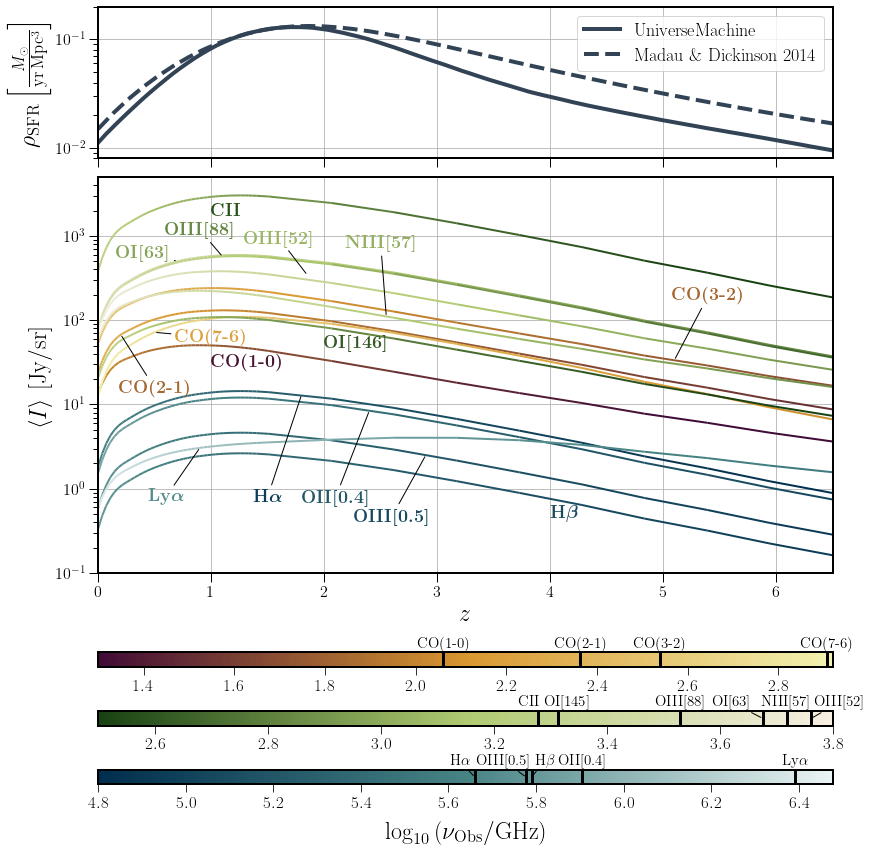

In [42]:
gs = gridspec.GridSpec(2, 1,left=0.11,bottom=0.08,right=0.96,top=0.98,wspace=.1,hspace=.05,
                       height_ratios=[1,4])
fig = plt.figure(figsize=(12,12))

ax = plt.subplot(gs[0,0])

#Top panel: SFRD
ax.semilogy(zz2,SFRD(zz2),lw=4,c=aonibi,label='UniverseMachine')
ax.plot(zvec,SFRD_PM,lw=4,c=aonibi,ls='--',label='Madau \& Dickinson 2014')

#labels and aesthetics
ax.set_xlim(0,zvec[-1])
ax.set_ylim(0.008,0.2)
ax.set_xticklabels([])
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.set_ylabel(r'$\rho_{\rm SFR}\left[\frac{M_\odot}{{\rm yr\,Mpc^3}}\right]$',fontsize=24)
ax.legend(loc=1,ncol=1,fontsize=18)
ax.grid()

################################

#Bottom panel: Intensities
gs_plot = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,0],hspace=0.3,wspace=0.,height_ratios=[3,1])

#limits for the color bars
maxi_blues = np.log10(3e6)
mini_blues = 4.8
delta_blues = maxi_blues-mini_blues
maxi_greens = 3.8
mini_greens = 2.5
delta_greens = maxi_greens-mini_greens
maxi_reds = 2.92
mini_reds = 1.3
delta_reds = maxi_reds-mini_reds
#normalize colorbars
norm = clrs.Normalize(vmin=mini_blues,vmax=maxi_blues)
cb_blues = cmap.ScalarMappable(cmap=blues, norm=norm)
cb_blues.set_array([])
norm = clrs.Normalize(vmin=mini_greens,vmax=maxi_greens)
cb_greens = cmap.ScalarMappable(cmap=greens, norm=norm)
cb_greens.set_array([])
norm = clrs.Normalize(vmin=mini_reds,vmax=maxi_reds)
cb_reds = cmap.ScalarMappable(cmap=reds, norm=norm)
cb_reds.set_array([])
#Aesthetics for line
arrowdict = dict(arrowstyle='-')

ax = plt.subplot(gs_plot[0,0])

#red lines (CO)
make_line(zz,I_CO_10_z(zz),ax,(np.log10(nuCO_10.value/(1+zz))-mini_reds)/delta_reds,reds,2)
ax.text(1,0.8*I_CO_10_z(1),r'\bf{CO(1-0)}', color=reds((np.log10(nuCO_10.value/(1+4))-mini_reds)/delta_reds),fontsize=18,weight='bold',ha='left',va='top')
make_line(zz,I_CO_21_z(zz),ax,(np.log10(nuCO_21.value/(1+zz))-mini_reds)/delta_reds,reds,2)
ax.annotate(r'\bf{CO(2-1)}',(.2,I_CO_21_z(.2)),(.5,20), color=reds((np.log10(nuCO_32.value/(1+4))-mini_reds)/delta_reds),fontsize=18,weight='bold',ha='center',va='top',arrowprops=arrowdict)
make_line(zz,I_CO_32_z(zz),ax,(np.log10(nuCO_32.value/(1+zz))-mini_reds)/delta_reds,reds,2)
ax.annotate(r'\bf{CO(3-2)}',(5.1,I_CO_32_z(5.1)),(5.4,250), color=reds((np.log10(nuCO_32.value/(1+4))-mini_reds)/delta_reds),fontsize=18,weight='bold',ha='center',va='top',arrowprops=arrowdict)
make_line(zz,I_CO_76_z(zz),ax,(np.log10(nuCO_76.value/(1+zz))-mini_reds)/delta_reds,reds,2)
ax.annotate(r'\bf{CO(7-6)}',(.5,I_CO_76_z(.5)),(1,80), color=reds((np.log10(nuCO_76.value/(1+4))-mini_reds)/delta_reds),fontsize=18,weight='bold',ha='center',va='top',arrowprops=arrowdict)
#green lines (fine-structure)
make_line(zz,I_CII_DL14_z(zz),ax,(np.log10(nuCII.value/(1+zz))-mini_greens)/delta_greens,greens,2)
ax.text(1,0.85*I_CII_DL14_z(1),r'\bf{CII}', color=greens((np.log10(nuCII.value/(1+4))-mini_greens)/delta_greens),fontsize=18,weight='bold',ha='left',va='top')
make_line(zz,I_NIII_z(zz),ax,(np.log10(nuNIII.value/(1+zz))-mini_greens)/delta_greens,greens,2)
ax.annotate(r'\bf{NIII[57]}',(2.55,I_NIII_z(2.55)),(2.5,1.4*I_OI63_z(0.6)), color=greens((np.log10(nuNIII.value/(1+4))-mini_greens)/delta_greens),fontsize=18,weight='bold',ha='center',va='bottom',arrowprops=arrowdict)
make_line(zz,I_OI63_z(zz),ax,(np.log10(nuOI63.value/(1+zz))-mini_greens)/delta_greens,greens,2)
ax.annotate(r'\bf{OI[63]}',(0.7,I_OI63_z(0.7)),(0.4,500), color=greens((np.log10(nuOI63.value/(1+4))-mini_greens)/delta_greens),fontsize=18,weight='bold',ha='center',va='bottom',arrowprops=arrowdict)
make_line(zz,I_OIII88_z(zz),ax,(np.log10(nuOIII88.value/(1+zz))-mini_greens)/delta_greens,greens,2)
ax.annotate(r'\bf{OIII[88]}',(1.1,I_OIII88_z(1.1)),(0.9,2*I_OI63_z(0.6)), color=greens((np.log10(nuOIII88.value/(1+4))-mini_greens)/delta_greens),fontsize=18,weight='bold',ha='center',va='bottom',arrowprops=arrowdict)
make_line(zz,I_OI145_z(zz),ax,(np.log10(nuOI145.value/(1+zz))-mini_greens)/delta_greens,greens,2)
ax.text(2,0.85*I_OI145_z(2),r'\bf{OI[146]}', color=greens((np.log10(nuOI145.value/(1+4))-mini_greens)/delta_greens),fontsize=18,weight='bold',ha='left',va='top')
make_line(zz,I_OIII52_z(zz),ax,(np.log10(nuOIII52.value/(1+zz))-mini_greens)/delta_greens,greens,2)
ax.annotate(r'\bf{OIII[52]}',(1.85,I_OIII52_z(1.55)),(1.6,1.6*I_OI63_z(0.6)), color=greens((np.log10(nuOIII52.value/(1+4))-mini_greens)/delta_greens),fontsize=18,weight='bold',ha='center',va='bottom',arrowprops=arrowdict)
#blue lines (optical and UV)
make_line(zz,I_Ha_z(zz),ax,(np.log10(nuHa.value/(1+zz))-mini_blues)/delta_blues,blues,2)
ax.annotate(r'\bf{H}$\boldsymbol{\alpha}$',(1.8,I_Ha_z(1.8)),(1.5,1), color=blues((np.log10(nuHa.value/(1+4))-mini_blues)/delta_blues),fontsize=18,weight='bold',ha='center',va='top',arrowprops=arrowdict)
make_line(zz,I_Hb_z(zz),ax,(np.log10(nuHb.value/(1+zz))-mini_blues)/delta_blues,blues,2)
ax.text(4,0.85*I_Hb_z(4),r'\bf{H}$\boldsymbol{\beta}$', color=blues((np.log10(nuHb.value/(1+4))-mini_blues)/delta_blues),fontsize=18,weight='bold',ha='left',va='top')
make_line(zz,I_OIII_z(zz),ax,(np.log10(nuOIII.value/(1+zz))-mini_blues)/delta_blues,blues,2)
ax.annotate(r'\bf{OIII[0.5]}',(2.9,I_OIII_z(2.9)),(2.6,0.6), color=blues((np.log10(nuOIII.value/(1+4))-mini_blues)/delta_blues),fontsize=18,weight='bold',ha='center',va='top',arrowprops=arrowdict)
make_line(zz,I_OII_z(zz),ax,(np.log10(nuOII.value/(1+zz))-mini_blues)/delta_blues,blues,2)
ax.annotate(r'\bf{OII[0.4]}',(2.4,I_OII_z(2.4)),(2.1,1.), color=blues((np.log10(nuOII.value/(1+4))-mini_blues)/delta_blues),fontsize=18,weight='bold',ha='center',va='top',arrowprops=arrowdict)
make_line(zz,I_Lya_z(zz),ax,(np.log10(nuLya.value/(1+zz))-mini_blues)/delta_blues,blues,2)
ax.annotate(r'\bf{Ly}$\boldsymbol{\alpha}$',(0.9,I_Lya_z(0.9)),(0.6,1.), color=blues((np.log10(nuLya.value/(1+4))-mini_blues)/delta_blues),fontsize=18,weight='bold',ha='center',va='top',arrowprops=arrowdict)

#labels and aesthetics
ax.semilogy()
ax.set_ylabel(r'$\langle I\rangle\,\left[{\rm Jy/sr}\right]$',fontsize=24)
ax.set_xlabel(r'$z$',fontsize=24)
ax.set_xlim(0,zvec[-1])
ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
fig.align_ylabels()

#colorbars: add ticks and labels
gs_plot2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_plot[1,0],wspace=0.,hspace=3,height_ratios=[1,1,1])

cbar = plt.colorbar(cb_reds,orientation='horizontal',cax=plt.subplot(gs_plot2[0,0]))
cbar.ax.tick_params(labelsize=17,size = 8.) 
nutick(nuCO_10,'CO(1-0)','black',cbar.ax)
nutick(nuCO_21,'CO(2-1)','black',cbar.ax)
nutick(nuCO_32,'CO(3-2)','black',cbar.ax)
nutick(nuCO_76,'CO(7-6)','black',cbar.ax)

cbar = plt.colorbar(cb_greens,orientation='horizontal',cax=plt.subplot(gs_plot2[1,0]))
cbar.ax.tick_params(labelsize=17,size = 8.) 
nutick(nuCII,'CII','black',cbar.ax,0.995)
nutick(nuNIII,'NIII[57]','black',cbar.ax,1.)
nutick(nuOI63,'OI[63]','black',cbar.ax,0.985,True)
nutick(nuOIII88,'OIII[88]','black',cbar.ax,1)
nutick(nuOIII52,'OIII[52]','black',cbar.ax,1.013,True)
nutick(nuOI145,'OI[145]','black',cbar.ax,1.005)

cbar = plt.colorbar(cb_blues,orientation='horizontal',cax=plt.subplot(gs_plot2[2,0]))
cbar.ax.tick_params(labelsize=17,size = 8.) 
nutick(nuLya,r'Ly$\alpha$','black',cbar.ax)
nutick(nuHa,r'H$\alpha$','black',cbar.ax,0.994,True)
nutick(nuHb,r'H$\beta$','black',cbar.ax,1.005,True)
nutick(nuOIII,r'OIII[0.5]','black',cbar.ax,0.991,True)
nutick(nuOII,r'OII[0.4]','black',cbar.ax)

cbar.ax.set_xlabel(r'$\log_{10}\left(\nu_{\rm Obs}/{\rm GHz}\right)$', fontsize=24,labelpad = 10)

plt.show()
